# 13 - Difference-in-Differences

## Three Billboards in the South of Brazil

제가 마케팅 일을 했을 때, 인터넷 광고가 가장 좋은 방법이었던 걸로 기억해요. 인터넷 광고가 매우 효율적이여서가 아니라(효율적이기도 하지만), 마케팅이 얼마나 효과적인지 아닌지를 파악하기가 매우 쉽기 때문입니다. 온라인 마케팅을 사용하면, 어떤 고객이 광고를 보았는지 알 수 있으며 쿠키를 사용하여 고객이 방문 페이지에 도달했는지 또는 다운로드 버튼을 클릭했는지 확인할 수 있습니다. 또한 머신러닝을 이용해서 여러분의 고객과 매우 유사한 잠재 고객을 찾고 해당 고객에게만 광고를 노출시킬 수 있습니다. 이러한 의미에서 온라인 마케팅은 매우 정확해요: 원하는 대상만 타겟팅하면, 여러분이 원하는 대로 반응하는지 확인할 수 있습니다.

그러나 모든 사람이 온라인 마케팅에 취약한 것은 아닙니다. TV 캠페인이나 거리에 광고판을 설치하는 것과 같이 덜 정확한 기술에 의존해야 할 때도 있어요. 대개 마케팅 채널의 다양성은 마케팅 부서에서 추구합니다. 그러나 온라인 마케팅이 특정 종류의 참치를 잡는 전문 낚싯대라면 광고판과 TV는 물고기 떼에 던지는 거대한 그물이라고 볼 수 있고, 적어도 그 중에서 몇 마리는 잡기를 희망합니다. 광고판과 TV 광고의 또 다른 문제는 마케팅이 얼마나 효과적인지 알기가 훨씬 더 어렵다는 것입니다. 물론, 광고판을 어딘가에 배치하기 전후의 구매량 또는 여러분이 추진하고 어떤 것이든 측정할 수 는 있어요. 지표의 증가가 있으면 마케팅이 효과적이라는 증거가 있습니다만, 이러한 증가가 마케팅한 제품 인지도의 자연스러운 추세가 아닌지 어떻게 알 수 있을까요? 즉, 애초에 광고판을 설치하지 않았다면, 어떻게 되었을지 counterfactual인 $Y_0$를 어떻게 알 수 있나요?

![img](./data/img/diff-in-diff/secrets.png)

이러한 유형의 질문에 답하는 한 가지 방법은 이중차분법(DID, Difference-in-Difference)입니다. DID는 일반적으로 거시적 개입(macro interventations)의 효과를 평가하는 데 사용되는데요, 예를 들어 이민이 실업에 미치는 영향, 범죄율에 대한 총기법 변경의 영향 또는 단순히 마케팅 캠페인으로 인한 유저 참여 차이를 추정하는데 사용됩니다. DID는 모든 경우에 개입 전후에 기간이 있으며, 일반적인 추세에서 개입의 영향을 파악하고자 하는 방법입니다. 위에서 설명한 예시처럼, 제가 이전에 대답해야 했던 것과 비슷한 질문에 대해 같이 한 번 살펴보시죠.

광고판이 마케팅 채널로 얼마나 좋은지 알아보기 위해, 히우그란지두술(Rio Grande do Sul) 주도인 포르투 알레그리(Porto Alegre)에 3개의 광고판을 설치했습니다. 이 실험을 통해 광고판 설치가 적금 계좌로 예금을 늘리는지 확인하고 싶었어요. 브라질 지리에 익숙하지 않은 분들께 참고로 말씀드리자면, Rio Grande do Sul은 브라질 남부에 있으며, 가장 발전된 지역 중 하나입니다.

이를 염두에 두고, 브라질 남쪽의 다른 수도인 산타 카타리나(Santa Catarina) 주의 주도인 플로리아노폴리스(Florianopolis)의 데이터도 살펴보기로 했습니다. Florianopolis를 대조군으로 사용해서, Porto Alegre와 비교 시 counterfactual $Y_0$를 추정해볼 수 있다는 것입니다. (참고로 이 부분은 기밀인 실제 실험이 아니지만 대조군 설정의 아이디어는 매우 유사해요). 우리는 6월 한 달 동안 Porto Alegre에 광고판을 배치했습니다. 실험을 통한 데이터는 다음과 같습니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf


%matplotlib inline

style.use("fivethirtyeight")

In [2]:
data = pd.read_csv("data/billboard_impact.csv")
data.head()

deposits  poa  jul
0        42    1    0
1         0    1    0
2        52    1    0
3       119    1    0
4        21    1    0

 예금(deposits)은 이 실험의 결과 변수이며 광고판을 통해 늘리려고 하는 변수라는 것을 기억해주세요. POA는 Porto Alegre 시 여부인지에 대한 더미변수(Dummy variable)입니다. 0이면 Florianopolis에서 가져온 데이터를 의미해요. 7월은 7월 또는 사후 개입 기간(post intervention period)에 대한 더미변수이며, 값이 0이면 개입 전 기간(pre-intervention period)인 5월의 데이터를 나타냅니다.

## DID 추정량 (DID Estimator)

시간과 Treatment 사이의 혼동을 피하기 위해, 이제부터 D를 사용하여 Treatment를 나타내고 T를 사용하여 시간을 표현하겠습니다. $Y_D(T)$를 기간 T의 처치 D에 대한 잠재적 결과라고 정의한다면, 우리가 반사실을 관찰할 수 있는 이상적인 세계에서 다음과 같은 방식으로 개입에 대한 처치 효과를 추정할 수 있습니다.

$
\hat{ATET} = E[Y_1(1) - Y_0(1)|D=1]
$

즉, 인과 효과는 개입 후 기간의 처치를 받은 대상의 결과에서 개입 후 기간의 처치를 받지않은 대상의 결과를 뺀 값입니다. 물론 $Y_0(1)$는 counterfactual 이기 때문에 관측할 수 없습니다.

이렇게 DID에서 인과추론의 근본적인 문제가 존재하게 되는데요. 이 문제를 해결하는 한 가지 방법은 전후 비교입니다.

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(0)|D=1]
$

위 예시에서는 광고판을 배치하기 전과 후에 POA의 평균 예금액을 비교할 수 있을 거에요.

In [3]:
poa_before = data.query("poa==1 & jul==0")["deposits"].mean()

poa_after = data.query("poa==1 & jul==1")["deposits"].mean()

poa_after - poa_before

41.04775

이 DID 추정량에 따르면, 개입 후 예금이 R$ 41.04 증가할 것으로 예상됩니다. 그런데 여러분 이 수치를 믿을 수 있을까요?

$E[Y(0)|D=1]=E[Y_0(0)|D=1]$ 식에 주목해주세요. 즉, **개입 전** 처치된 대상에 대해 관찰된 결과는 개입 이전에도 처치된 대상에 대한 반사실 결과와 동일해요. 이 식을 사용해서 **개입 후** counterfactual $E[Y_0(1)|D=1]$를 추정하기 때문에, 이 추정은 $E[Y_0(1)|D=1] = E[ Y_0(0)|D=1]$를 가정합니다.

개입이 없을 경우, 후반 기간의 결과는 시작 기간의 결과와 같을 거에요. 결과 변수가 어떤 종류의 추세를 따른다면, 위의 식은 맞지 않을 겁니다. 예를 들어, POA에서 예금이 증가한다면, $E[Y_0(1)|D=1] > E[Y_0(0)|D=1]$, 즉, 개입이 없더라도 후반 기간의 결과는 시작 기간의 결과보다 클 거에요.
비슷하게 반대의 경우를 살펴보면, 예금이 POA에서 감소추세라면, $E[Y_0(1)|D=1] < E[Y_0(0)|D=1]$ 가 됩니다. 이것은 전후에 대한 부분이 좋은 추정량이 아니라는 것을 보여줍니다.

또 다른 방법은 처치를 받은 그룹과 개입을 받지 않은 미처치 그룹을 비교하는 것 입니다.

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(1)|D=0]
$

해당 예시에서는 개입 후 기간에 POA의 예금을 Florianopolis의 예금과 비교하고 있어요.

In [4]:
fl_after = data.query("poa==0 & jul==1")["deposits"].mean()
poa_after - fl_after

-119.10175000000001

해당 추정량은 캠페인이 긍정적인 효과를 가져오지 못하고, 소비자들의 예금은 R$ 119.10 감소할 것이라고 이야기하고 있어요.

$E[Y(1)|D=0]=E[Y_0(1)|D=0]$이라는 점을 주목해주세요. 그리고 $E[Y(1)|D=0]$를 사용해서 개입 후 처치에 대한 counterfactual을 추정하기 때문에, 누락된 counterfactual을 다음과 같이 대체할 수 있다고 가정해볼게요. $E[Y_0(1)|D =0] = E[Y_0(1)|D=1]$. 그런데, 이 식은 두 그룹의 수준이 매우 유사한 경우에만 해당됩니다. 예를 들어, Florianopolis가 Porto Alegre보다 예금이 훨씬 많다면 $E[Y_0(1)|D=0] > E[Y_0(1)|D=1]$이기 때문에 위 식은 맞지 않게 됩니다. 반대로, Florianopolis의 예금 수준이 Porto Alegre보다 낮으면 $E[Y_0(1)|D=0] < E[Y_0(1)|D=1]$가 되겠죠?

거듭 말씀드리지만, 이건 좋은 생각이 아니에요. 이 부분을 해결하기 위해, 공간(space) 비교와 시간(time) 비교를 모두 사용할 수 있습니다. 이게 바로 DID에 대한 기본적인 아이디어입니다. 아래와 같이 같이 관측할 수 없는 counterfactual을 대체해 효과를 추정할 수 있습니다.

$
E[Y_0(1)|D=1] = E[Y_1(0)|D=1] + (E[Y_0(1)|D=0] - E[Y_0(0)|D=0])
$

위 식은 **개입 전** 처치된 그룹에 추세 구성 요소를 추가된 것을 보여주고 있어요. 대조군 $E[Y_0(1)|D=0] - E[Y_0(0)|D=0 을 사용하여 추정합니다. 다시 말해, **개입 후** 실험군이 만약 처치를 받지 않았다면, **처치 전** 실험군에 대조군의 성장과 동일한 성장 요소를 더한 것처럼 보일 것입니다.

실험군과 대조군의 추세(trend)는 같다고 가정한다는 점은 주목할 필요가 있습니다.

$
E[Y_0(1) − Y_0(0)|D=1] = E[Y_0(1) − Y_0(0)|D=0]
$

여기서 왼쪽 부분은 counterfactual에 대한 추세입니다. 이제 처치 효과 정의 $E[Y_1(1)|D=1] - E[Y_0(1)|D=1]$에서 추정된 counterfactual에을 대체할 수 있게 됩니다.

$
\hat{ATET} = E[Y(1)|D=1] - (E[Y(0)|D=1] + (E[Y(1)|D=0] - E[Y(0)|D=0])
$

이 식을 재정리하면, 아래처럼 DID 추정량을 얻습니다.

$
\hat{ATET} = (E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0])
$

처치 후와 처치 전의 대조군과 실험군 처치의 차이를 따서 붙여진 이름입니다.

아래 코드를 한 번 보시죠.

In [5]:
fl_before = data.query("poa==0 & jul==0")["deposits"].mean()

diff_in_diff = (poa_after-poa_before)-(fl_after-fl_before)
diff_in_diff

6.524557692307688

위 식을 통해 추정된 DID는 예금이 고객 당 R$ 6.52만큼 증가할 것이라고 예상하고 있습니다. DID가 만드는 가정은 앞서 이야기한 다른 2개의 추정량보다 훨씬 더 그럴듯하지 않나요? 여기서는 두 도시 간의 성장 패턴이 동일하다고 가정합니다. 그러나 동일한 수준을 가질 필요도 없고 추세가 0일 필요도 없습니다.

DID에 대해 시각화하기 위해, 처치되지 않은 그룹에서 처치된 그룹으로의 성장 추세를 투영하여 반사실, 즉 개입이 없는 경우 예상해야 하는 예금수를 볼 수 있습니다.

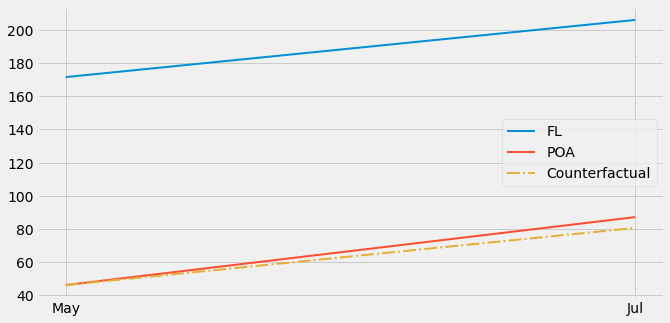

In [6]:
plt.figure(figsize=(10,5))
plt.plot(["May", "Jul"], [fl_before, fl_after], label="FL", lw=2)
plt.plot(["May", "Jul"], [poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)],
         label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();


빨간색 선과 노란색 점선 사이의 작은 차이가 보이시나요? 만약 여러분이 이 차이에 정말 주목하신다면, Porto Alegre에 대한 작은 처치 효과를 확인하실 수 있습니다.

![img](./data/img/diff-in-diff/cant-read.png)

이제, 여러분이 스스로에게 이렇게 물어볼 수 있을 거에요. "과연 내가 추정량을 얼마나 신뢰할 수 있을까요? 해당 추정량에 대한 표준오차를 갖는 건 내 권리에요!". 표준 오차가 없는 추정량은 어리석게 보일 수 있기 때문에 의미가 있어요. 이 부분을 해결하기 위해, 회귀(regression)를 사용하는 깔끔한 방법을 사용해보려고 합니다. 구체적으로는 다음 선형 모델을 추정합니다.

$
Y_i = \beta_0 + \beta_1 POA_i + \beta_2 Jul_i + \beta_3 POA_i*Jul_i + e_i
$

$\beta_0$는 대조군에 대한 기준선이며, 이 경우에는 5월 Florianopolis의 예금 수준을 나타냅니다. 처치된 도시의 더미변수가 1인 경우를 보면, $\beta_1$를 얻게 됩니다. 따라서 $\beta_0 + \beta_1$는 개입 전 5월의 Porto Alegre 기준선이고 $\beta_1$는 Florianopolis 위의 Porto Alegre 기준선의 증가분입니다. POA 더미변수가 0이고 7월 더미변수가 1인 경우를 고려한다면, 개입 기간 후 7월 Florianópolis 수준인 $\beta_0 + \beta_2$를 얻습니다. $\beta_2$는 대조군의 추세를 나타냅니다. 왜냐하면 개입 후, 기간에 통제 수준을 얻기 위해 기준선 위에 추가하기 때문입니다. 
요약하자면, $\beta_1$은 대조군에서 처치된 그룹으로 이동해 얻을 수 있는 증분이고, $\beta_2$는 개입 전 기간에서 개입 후 기간으로 이동하여 얻는 증분입니다. 마지막으로 두 더미변수가 모두 1이라면, $\beta_3$가 나타나게 됩니다. $\beta_0 + \beta_1 + \beta_2 + \beta_3$는 개입 후 Porto Alegre의 수준입니다. 따라서 $\beta_3$는 5월에서 7월로, Florianopolis에서 Porto Alegre 이동할 때의 증분 영향입니다. 즉, 이 부분은 DID 추정량이 됩니다.

믿기 힘드시다면, 직접 확인해 보세요. 위에서 얻은 것과 수치를 얻어야 해요. 또한 앞서 추가적으로 알고 싶었던 표준 오차를 얻는 방법에 주목해주세요.

In [7]:
smf.ols('deposits ~ poa*jul', data=data).fit().summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

## 평행하지 않은 추세 (Non Parallel Trends)

DID의 한 가지 분명한 문제는 평행 추세 가정을 만족하기가 쉽지 않다는 것입니다. 처치를 받은 그룹의 증가 추세가 대조군의 경향과 다르면 DID는 편향될 거에요. 특정 지역에 처치를 하는 결정이 처치에 잘 반응할 가능성을 기반으로 하거나, 처치가 잘 수행되지 않는 지역을 대상으로 하는 경우 무작위가 아닌 데이터에서 나타날 수 있는 일반적인 문제입니다. 우리가 다루고 있는 마케팅 사례를 살펴보시죠. 광고판의 전반적인 효과를 확인하기 위해서가 아닌 Porto Alegre에서 광고판을 테스트하기로 했습니다. 그 이유는 단순히 판매 실적이 좋지 않기 때문입니다. 아마도 온라인 마케팅이 작동하지 않을 거에요. 이 경우 광고판이 없는 Porto Alegre에서 볼 수 있는 성장은 다른 도시에서 관찰한 성장보다 낮게 관찰될 수 있겠죠? 이는 Porto Alegre에 있는 광고판의 효과를 과소평가하게 만들 수 있을 거에요.

이러한 평행 추세가 아닌 경우가 발생하는지 확인하는 한 가지 방법은 과거 기간을 이용해 추세를 그려보는 거에요. 예를 들어, Porto Alegre는 약간의 감소 추세를 보였지만 Florianopolis는 가파른 상승세를 보였다고 가정해 보겠습니다. 이 경우, 이전의 기간을 표시하면 아래 그림과 같이 추세가 나타날 것이고, 우리가 구한 DID 추정량이 신뢰할 수 있는 값이 아님을 알 수 있습니다.

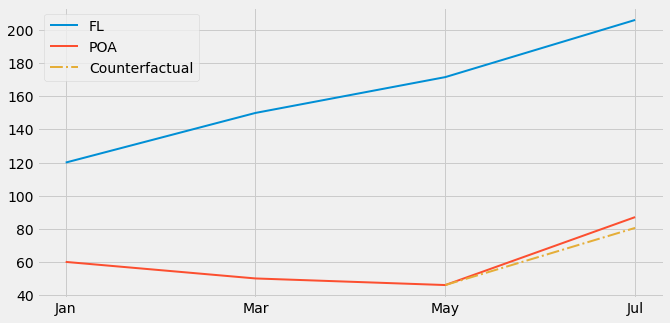

In [8]:
plt.figure(figsize=(10,5))
x = ["Jan", "Mar", "May", "Jul"]

plt.plot(x, [120, 150, fl_before,  fl_after], label="FL", lw=2)
plt.plot(x, [60, 50, poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)], label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

Chapter 15에서 Synthetic control이라는 방법을 통해 이 문제를 해결하는 방법을 살펴볼 예정입니다. Synthetic control을 사용해, 여러분이 관심이 있는 도시의 추세를 밀접하게 따르는 인위적인 도시를 생성하는 방법론입니다. 그러나 이번 챕터에서는 DID를 적용할 때, 평행 추세가 있는지 항상 확인해야 한다는 것을 기억해주세요.

![img](./data/img/diff-in-diff/non-parallel.png)

마지막으로 언급할 문제는 집계된 데이터만 있는 경우, DID 추정량에 신뢰 구간을 둘 수 없다는 점입니다. 예를 들어 Florianópolis 또는 Porto Alegre의 각 고객들에 대한 데이터가 없다고 가정해 보겠습니다. 대신에 두 도시의 개입 전후의 평균 예금에 대해 집계된 데이터가 있습니다. 이 경우 DID로 인과 효과를 추정할 수는 있으나 추정량에 대한 분산은 알 수 없습니다. 데이터의 모든 변동성이 집계를 통해 제거되었기 때문입니다.

## Key Ideas

이번 챕터에서 더 많은 거시적 단체/그룹(학교, 도시, 주, 국가 등)에서 인과 관계를 추정할 때 널리 적용되는 DID 방법론에 대해 탐구했습니다. DID는 실험군에 대해 처치 전과 후의 결과를 파악하고 대조군 추세와 비교합니다. 이번 장에서는 도시별 마케팅 캠페인의 효과를 추정할 때, DID가 어떻게 적용될 수 있는지 살펴보았습니다.

마지막으로 처치된 그룹과 대조군의 추세가 동일하지 않을 때, DID가 제대로 작동하지 않는 경우에 대해 살펴보았습니다. 또한 집계된 데이터만 있는 경우 DID가 얼마나 문제가 되는지도 확인해볼 수 있었어요.

## References

이 책을 쓰기 위해 Joshua Angrist, Alberto Abadie, Christopher Walters의 대단한 계량 경제학 수업 자료를 많이 참고했습니다. 해당 자료에 있는 대부분의 아이디어는 전미경제학회(American Economic Association)의 수업에서 가져왔어요. 이렇게 좋은 참고자료를 보는 것이 2020년의 힘든 한 해를 지탱하게 만들어준 원동력이었다고 생각해요.

* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

또한, Angrist의 정말 좋은 책들을 참고자료에 넣고 싶어요. 해당 저자가 쓴 책들은 계량경제학(Econometrics) 또는 '메트릭스(Metrics, 계량적 분석)'가 매우 유용할 뿐만 아니라 매우 흥미롭다는 걸 알려주었어요.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering ‘Metrics](https://www.masteringmetrics.com/)

마지막으로 참고한 자료는 Miguel Hernan과 Jamie Robins의 책입니다. 이 책들은 제가 대답해야 했던 까다로운 인과적인 질문에서 신뢰할 수 있는 동반자 같은 존재였어요.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

마지막으로, Scott Cunningham과 인과 추론과 Mixtape 형태를을 결합한 훌륭한 자료에도 감사를 전합니다.

* [Causal Inference: The Mixtape](https://www.scunning.com/mixtape.html)

![img](./data/img/poetry.png)

## Contribute

Causal Inference for the Brave and True는 인과추론, 통계학에 대한 오픈소스 자료입니다. 이 자료는 금전적으로나 모든 분들이 쉽게 접근하실 수 있도록 하는 것이 목표입니다. 또한, 이 책은 Python 기반의 무료 소프트웨어만 사용해요.
여러분들께서 이 자료가 가치 있다고 생각하시고, 금전적으로 지원을 원하신다면 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true)를 방문해주세요. 
만약 여러분이 금전적으로 기여하기가 쉽지 않으시다면, 오타 수정, 수정 제안, 이해하기 난해한 부분에 대한 피드백 제공 등을 통해 도움을 주실 수 있어요. 이 책의 Github 저장소 [이슈 페이지](https://github.com/CausalInferenceLab/Causal-Inference-with-Python/issues)를 방문해주세요. 마지막으로 이 자료가 여러분의 마음에 드셨다면 도움이 될 수 있는 다른 사람들과 공유해주시고, [한국어 번역 자료](https://github.com/CausalInferenceLab/Causal-Inference-with-Python/stargazers)와 [해당 번역본의 원서](https://github.com/matheusfacure/python-causality-handbook/stargazers)에 star 부탁드립니다!